# UK Food CPI (MoM%) Forecast


## Project Summary

This Analysis utilizes the **UK Consumer Price Index (CPI) - Food and Non-Alcoholic Beverages** monthly rae time series. The data was cleaned and **EDA** performed on it, to give a **short-term predicion** using some selected models **(Naive, Seasonal-Naive, SARIMA,** and **Prophet).**
Prediction outputs would be saved and visualized in **Streamlit** app.

## Skills Demonstrated 
- Data Cleaning (Using Official statistics/monhly time series)
- Exploratory Data Analysis **(EDA).**
- Prediction **(Naive, Seasonal, SARIMA,** and **Prophet)**
- Model evaluation **(MAPE, RSME)**
- Logical communication and thinking

## Function Declaration

In [1]:
# Importing neccessary libraries
import pandas as pd, numpy as np, seaborn as sns
import re
import calendar
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
def load_csv_file(file_path, col_names=['label', 'value'], header_row=0, preview_rows=10):
    """
    Loads a CSV file into a pandas DataFrame with chosen column names and preview.

    Parameters:
    - file_path (str): The path of the CSV file.
    - col_names (list): Column names to assign to the DataFrame.
    - header_row (int): Row number to treat as header (0 = first row).
    - preview_rows (int): Number of rows to print for preview.

    Returns:
    - pd.DataFrame: Loaded DataFrame.
    """
    df = pd.read_csv(file_path, names=col_names, header=header_row)
    print(df.head(preview_rows))
    return df


In [3]:
def forecast_evaluation(y_true, y_pred, name):
    """
    Evaluate the performance of a forecasting or predictive model.

    Parameters:
    -----------
    y_true : array-like
        Dataset actual values.
    y_pred : array-like
        Model predicted values.
    name : (str)
        A name for result printing purpose

    Returns:
    --------
    tuple (mape, rmse) :
        mape : (float)
            Mean Absolute Percentage Error will show average prediction error in %.
        rmse : (float)
            Root Mean Squared Error will measure deviation level between the predicted and from actual values.
    """

    # Gets average percentage difference between actual and the predicted value
    mape = mean_absolute_percentage_error(y_true, y_pred)
    # Gets and checks larger errors heavily (manual sqrt avoids 'squared' arg)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f'{name} = MAPE: {mape:.3f} | RMSE: {rmse:.3f}')
    return mape, rmse

## 1) Load and clean the dataset to a straightforward data for usability purpose

The dataset will be cleaned and saved into a new CSV file to avoid alteration of the original dataset. The new CSV file will contain date (in proper formats), category and value(MoM%) for the **UK Consumer Price Index (CPI) - Food and Non-Alcoholic Beverages.**

In [4]:
# Loads the original data
df_original = load_csv_file("series-270925.csv")

               label            value
0               CDID             D7JH
1  Source dataset ID             MM23
2            PreUnit              NaN
3               Unit                %
4       Release date       17-09-2025
5       Next release  22 October 2025
6    Important notes              NaN
7           1988 FEB              0.6
8           1988 MAR              0.3
9           1988 APR              0.6


In [5]:
# The re(regex) module is used to ge rows that matches the YYY MON format
mask = df_original['label'].str.match(r"^\d{4}\s+[A-Z]{3}$", na = False) 

# Gets the first index that starts with he proper required data
first_idx = mask.idxmax()
print (f'First index data row = row {first_idx}')

# The work dataframe starts from there
cpi_data = df_original.loc[first_idx:].copy()

First index data row = row 7


In [6]:
# The date column is cleaned using the following code
cpi_data['date'] = pd.to_datetime(cpi_data['label'], format='%Y %b')

# All entries in the value column is coverted to a numeric format
cpi_data['value'] = pd.to_numeric(cpi_data['value'], errors = 'coerce')

# The odd column attributes labels are dropped
cpi_data = cpi_data.drop(columns = ['label'])

In [7]:
# A new labelling will be inputed to clarify what these series represent
cpi_data['category'] = 'Food & Non-Alcoholic Beverages(MoM%)'

# Columns are re arranged to a standard usable format
cpi_data = cpi_data[['date', 'category', 'value']]

# Rows index are sorted by date
cpi_data = cpi_data.sort_values('date').reset_index(drop = True)

In [8]:
# The cleaned_cpi will be outputed and saved in a new file "cleaned_cpi.csv" for analysis purpose
output_path = 'cleaned_cpi.csv'
cpi_data.to_csv(output_path, index = False) # ouput pah is saved into "cleaned_cpi.csv"

print (f'Cleaning Completed and saved as "{output_path}"')

Cleaning Completed and saved as "cleaned_cpi.csv"


In [20]:
# Set 'date' as the time series index and extract the value series
cpi_series = cpi_data.set_index('date')['value']

In [10]:
# Function is re-used to load the cleaned _csv data file
cleaned_cpi = load_csv_file("cleaned_cpi.csv", col_names=["date", "category", "value"])

# Converting date clolumn to a proper datetime object and seting it to month(M) period
# while converting back to a standard timesamp
cleaned_cpi['date'] = pd.to_datetime(cleaned_cpi['date']).dt.to_period('M').dt.to_timestamp()

# Describing the statistical summary of all the numeric columns in he cleaned_csv data
cleaned_cpi.describe()

         date                              category  value
0  1988-02-01  Food & Non-Alcoholic Beverages(MoM%)    0.6
1  1988-03-01  Food & Non-Alcoholic Beverages(MoM%)    0.3
2  1988-04-01  Food & Non-Alcoholic Beverages(MoM%)    0.6
3  1988-05-01  Food & Non-Alcoholic Beverages(MoM%)    0.3
4  1988-06-01  Food & Non-Alcoholic Beverages(MoM%)    0.2
5  1988-07-01  Food & Non-Alcoholic Beverages(MoM%)   -0.9
6  1988-08-01  Food & Non-Alcoholic Beverages(MoM%)    0.5
7  1988-09-01  Food & Non-Alcoholic Beverages(MoM%)    0.4
8  1988-10-01  Food & Non-Alcoholic Beverages(MoM%)    0.2
9  1988-11-01  Food & Non-Alcoholic Beverages(MoM%)    0.7


,date,value
count,451,451.000000
mean,2006-10-31 13:24:36.718403584,0.240798
min,1988-02-01 00:00:00,-2.100000
25%,1997-06-16 00:00:00,-0.200000
50%,2006-11-01 00:00:00,0.200000
75%,2016-03-16 12:00:00,0.650000
max,2025-08-01 00:00:00,2.800000
std,NaN,0.653927


## 2) Exploratory Data Analysis  
The goal of this analysis is to understand the variability, trends and the seasonal difference of monthly food inflation before any forecasting wil be done. This helps stakesholders understand and interpret the data, and as well, helps us best select what best model is most useful.

Data Visualizaion
The below listed plot will be visualized to understand the data distribution, variabiliy, trends, inflaion dynamics, seasonal effects and more.

- Violin plot - Monthly Seasonality
- Lineplot -Trend over time/12-month average
- Histplot - Distribution of monthly inflation

Violinplot will be used to visualize how inflation (monthly) values are spread among months cross the full time series. This will be used to reveal seasonal inflation patern and seasonal volatility


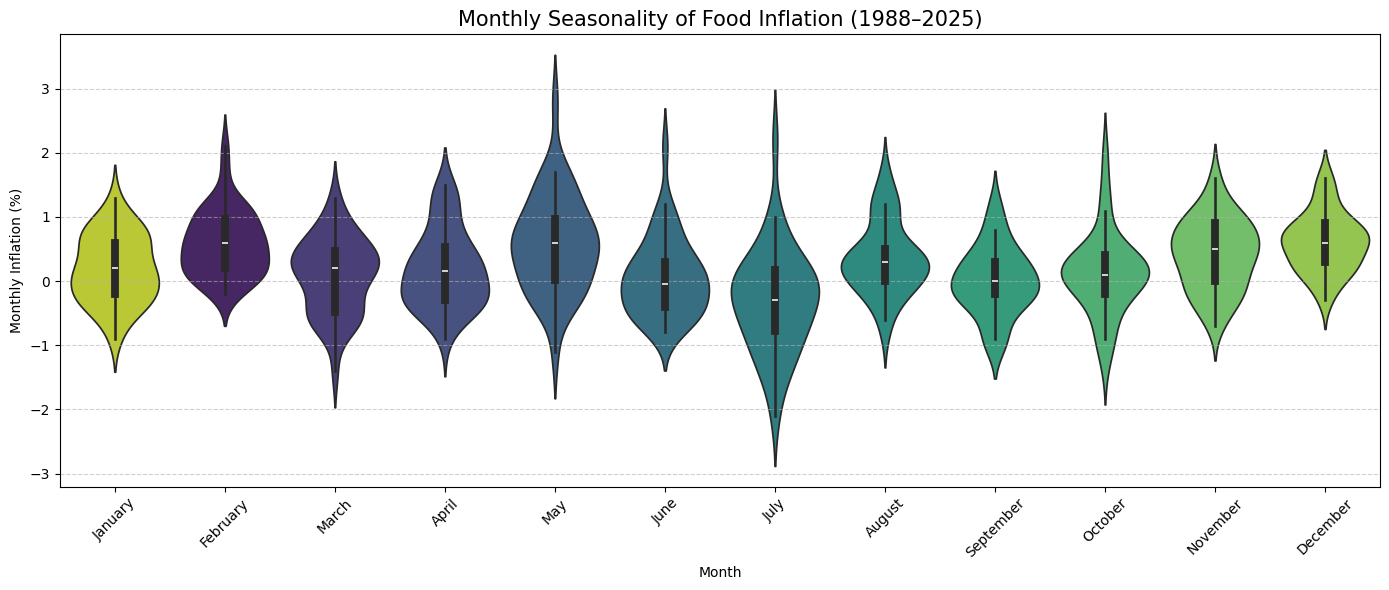

In [34]:
print('Violinplot will be used to visualize how inflation (monthly) values are spread among months cross the full time series. This will be used to reveal seasonal inflation patern and seasonal volatility')


# Creating a month column for understading purpose
cleaned_cpi['month'] = cleaned_cpi['date'].dt.month
cleaned_cpi['month_name'] = cleaned_cpi['month'].apply(lambda x: calendar.month_name[x])

plt.figure(figsize=(14, 6))
sns.violinplot(
    data=cleaned_cpi,
    x='month_name',
    y='value',
    hue = 'month_name',
    order=list(calendar.month_name[1:]),   # Sorting month in an orderly manner(Jan - Dec)
    inner='box',                           # IQR/median would be displayed using smaller boxplot
    palette='viridis'
)

plt.xticks(rotation=45)
plt.title('Monthly Seasonality of Food Inflation (1988–2025)', fontsize=15)
plt.xlabel('Month')
plt.ylabel('Monthly Inflation (%)')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

- Inflation distribution each month across 30+ years is perfectly described by the shape of the violin in the plot
- Narrower violins means stable months which implies the consistency of inflation pattern
- Wider violins means high variability which implies unpredictable months (January - March)
- There is a very high level of monthly differences which suggest the essentiality of seasonal terms

Lineplot will be used to visualize overall direction and the macro-trend of the monthly inflation of UK food over time and also, a 12-month rolling mean to highlight shifts and smooth short-term noise




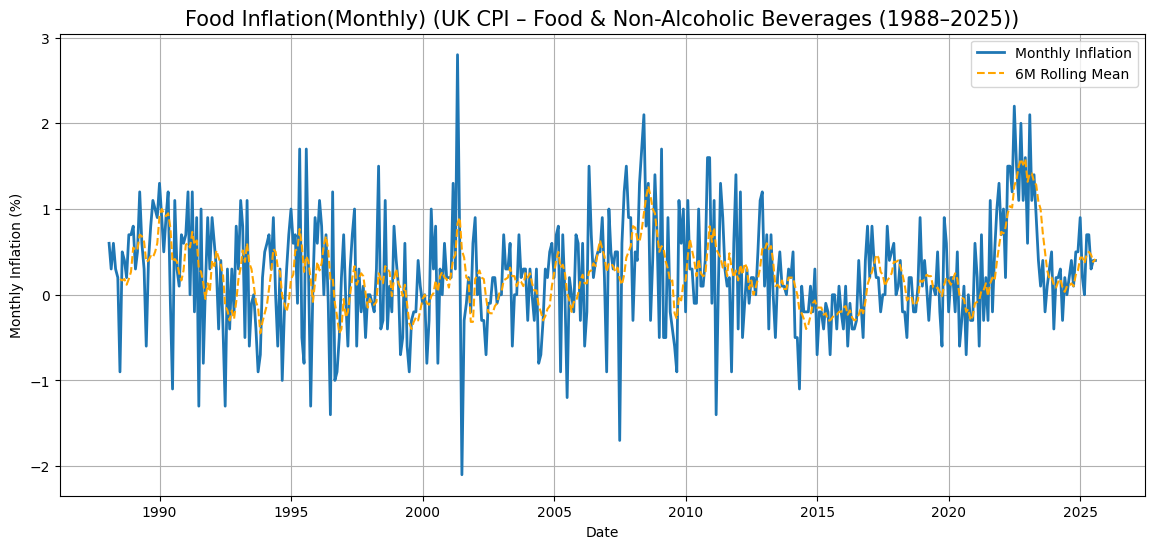

In [32]:
print('Lineplot will be used to visualize overall direction and the macro-trend of the monthly inflation of UK food over time and also, a 12-month rolling mean to highlight shifts and smooth short-term noise\n\n')

plt.figure(figsize=(14, 6))
sns.lineplot(data=cleaned_cpi, x='date', y='value', label='Monthly Inflation', linewidth=2)
sns.lineplot(data=cleaned_cpi, x='date', y=cleaned_cpi['value'].rolling(6).mean(), label='6M Rolling Mean', linestyle='--', color='orange')
plt.title('Food Inflation(Monthly) (UK CPI – Food & Non-Alcoholic Beverages (1988–2025))', fontsize=15)
plt.xlabel('Date')
plt.ylabel('Monthly Inflation (%)')
plt.legend()
plt.grid(True)
plt.show()

- 6 - month rolling average smooths shrt-term noise and reveals macro-trend
- Through the observation of inflation level (above pandemic level), Cost of living in the UK is sustained
- In 2000 - 2019, inflation remaind relatively stable with occasional spikes
- There is a visible structural shift beween 2021 and 2023, revealing rising food costs')

Histplot will be used explain the variability and the shape  of monthly inflation of UK food for 30+ years




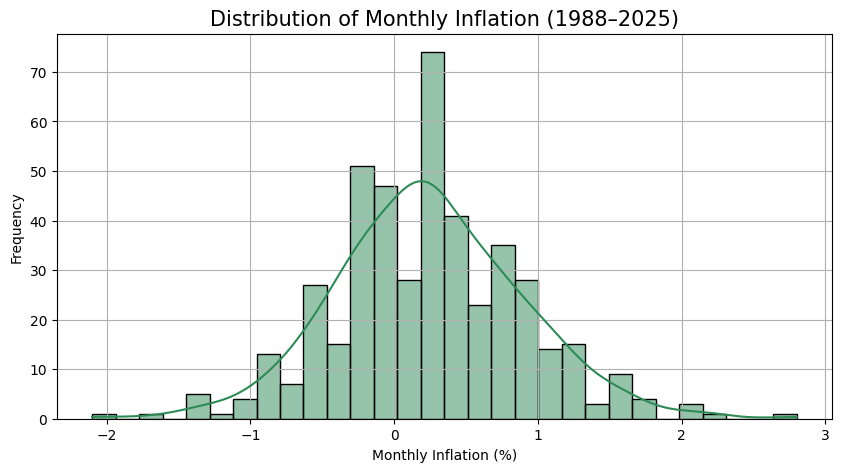

In [33]:
print('Histplot will be used explain the variability and the shape  of monthly inflation of UK food for 30+ years\n\n')

plt.figure(figsize=(10, 5))
sns.histplot(cleaned_cpi['value'], bins=30, kde=True, color='seagreen')
plt.title('Distribution of Monthly Inflation (1988–2025)', fontsize=15)
plt.xlabel('Monthly Inflation (%)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

- Cluster of month changes is predominantly within 0 - 0.5%, displaying th levels of volatility
- There is a re-occurence of both inflation and deflation periods which is most often than not, linked to macreconomic slowdown
- There is an extreme price inflation which is revelaed through he right tail')

## 3) Baseline Forecasting **(Naïve & Seasonal-Naïve)**

Baseline models will help provide a performance reference, a simple one for forecasting purpose. Normally, advanced models (SARIMA or prophet) should always outperform these baselines models, else, there is no forecast value. 

In [35]:
# The last 12 months (test set) will be used to carry out the test function for future prediction
# to know how good it can predict data its no familiar with
train = cleaned_cpi.iloc[:-6].copy() # Includes all data except last 12 months for training
test = cleaned_cpi.iloc[-6:].copy() # Include just only the most recent 12 months for testing

# Using Naive forecast to predict each months future as the last observed values from training data
naive_forecast = np.repeat(train['value'].iloc[-1], len(test))

# Using seasonal naive to predict each future month as same exact value from previous 12 months and
# this baseline also assumes srong seasonality( per year)
seasonal_naive_forecast = cleaned_cpi['value'].shift(6).iloc[-6:]

# Both baselines (Naive and seasonal Naive will be evaluated)
naive_mape, naive_rmse = forecast_evaluation(test['value'], naive_forecast, 'Naive')
seasonal_mape, seasonal_rmse = forecast_evaluation(test['value'], seasonal_naive_forecast, 'Seasonal Naive')

Naive = MAPE: 150119987579017.031 | RMSE: 0.324
Seasonal Naive = MAPE: 300239975158033.688 | RMSE: 0.385


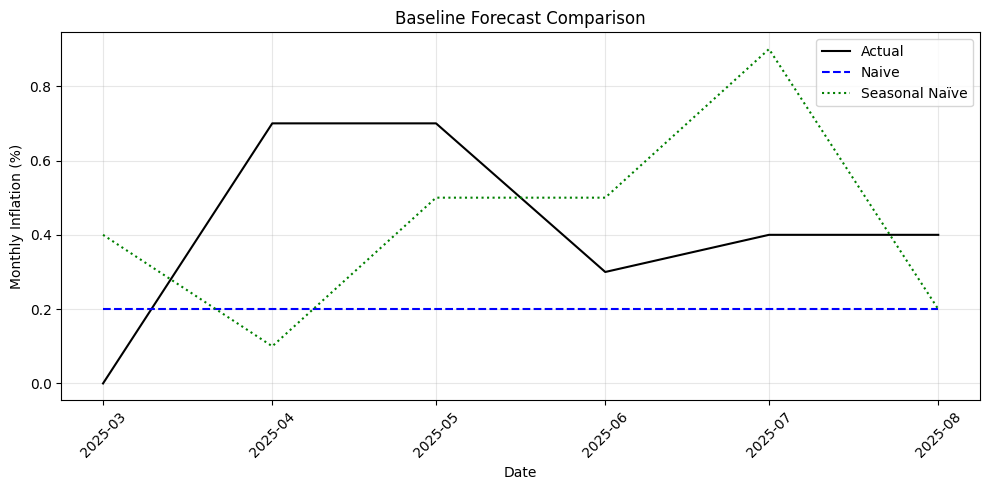

In [36]:
plt.figure(figsize=(10, 5))

# plots the actual test data
plt.plot(test['date'], test['value'], label='Actual', color='black')

# plots the Naive forecast data
plt.plot(test['date'], naive_forecast, label='Naive', color='blue', linestyle='--')

# Plots the Seasonal Naive forecast
plt.plot(test['date'], seasonal_naive_forecast.values, label='Seasonal Naïve', color='green', linestyle=':')

plt.title('Baseline Forecast Comparison')
plt.xlabel('Date')
plt.ylabel('Monthly Inflation (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- The black line represent the actual data
- The Naive forecast line(blue) is flat which is normal, it assumes here is no change
- The Seasonal Naive forecast line (green) diverts so well from the actual inflation, which implies the insufficient use of trends to make predictions
- Therefore, there is a need for  more advanced forecast models **(SARIMA, Prophet)** as they work well when it comes to structural shift in data

## 4) Advanced Forecasting **(SARIMA and Prophet)**

**SARIMA**  
In this project, the SARIMA model will help me capture and forecast the underlying seasonal patterns and trends in monthly food inflation based on historical data. By modelling how past values influence future outcomes, it will help provide a reliable and interpretable forecast that reflects real economic behaviours, such as recurring seasonal fluctuations and long-term changes in price levels.
It will allow me to compare predicted inflation against actual results and assess whether my approach adds real forecasting value. Normally, SARIMA should outperform the baseline models.

In [41]:
# Fit SARIMA (simple default order, can tune later)
sarima_model = SARIMAX(train["value"], order=(2, 1, 2), seasonal_order=(2, 1, 2, 12))
sarima_result = sarima_model.fit(disp=False)

# Forecast 12 months ahead
sarima_forecast = sarima_result.forecast(steps=6)

# Evaluation
sarima_mape, sarima_rmse = forecast_evaluation(test["value"], sarima_forecast, "SARIMA")

SARIMA = MAPE: 76575583197981.703 | RMSE: 0.223


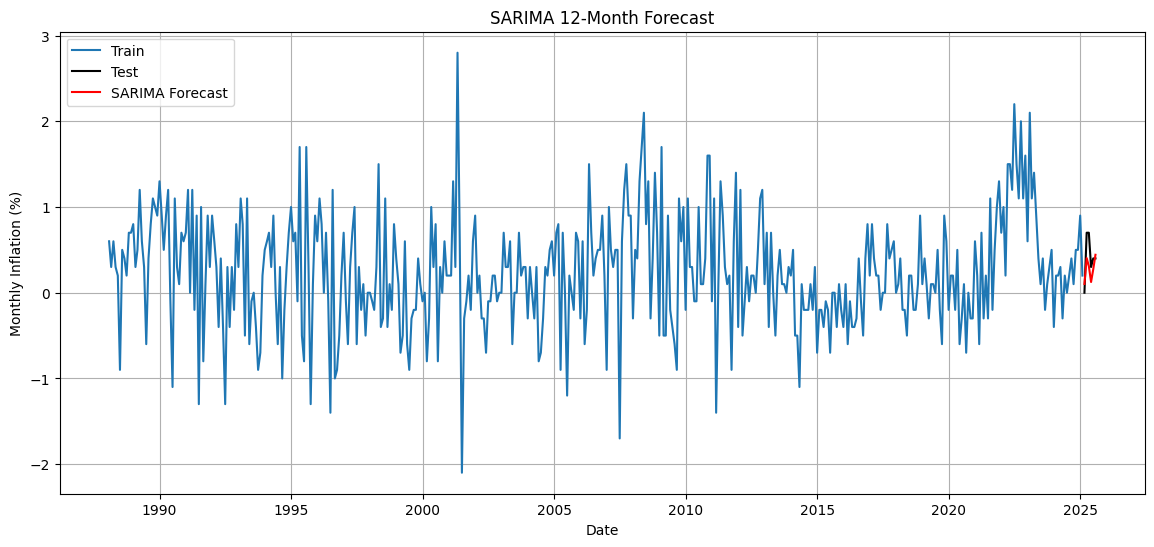

In [42]:
plt.figure(figsize=(14, 6))
plt.plot(train["date"], train["value"], label="Train")
plt.plot(test["date"], test["value"], label="Test", color="black")
plt.plot(test["date"], sarima_forecast, label="SARIMA Forecast", color="red")
plt.title("SARIMA 12-Month Forecast")
plt.xlabel("Date")
plt.ylabel("Monthly Inflation (%)")
plt.legend()
plt.grid(True)
plt.show()

**Prophet**  
In this project, the Prophet model will help generate robust and flexible forecasts that adapt to changes in trend and seasonal behaviour within the inflation data. Its ability to automatically capture non-linear patterns and provide uncertainty intervals makes it valuable for understanding not only the most likely future inflation path but also the range of possible outcomes.
This will support better interpretation and decision-making based on forecast scenarios. Normally, Prophet should outperform the baseline models.

If they boh, do not outperform the baseline models, then their added complexity would not contribute meaningful improvements to the forecast process.